In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import re

# ML libraries
from sklearn.metrics import (auc, classification_report,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# NLP libraries
# Install spacy
# !pip install spacy
# Download the English language model
# !python -m spacy download en
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# NLTK
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Progress bar
from tqdm import tqdm

#%% Constants
TARGET_NAMES = ['negative','positive']

# !pip install --upgrade tensorflow
# !nvidia-smi

**Dataset**

In [2]:
csv_file_path = "C:\\Users\\melin\\Downloads\\IMDB Dataset.csv\\IMDB Dataset.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
df.shape

(50000, 2)

In [4]:
df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<Axes: xlabel='sentiment', ylabel='count'>

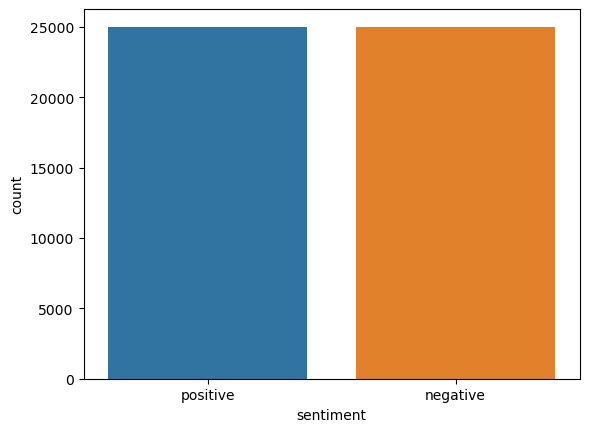

In [5]:
sns.countplot(x="sentiment", data=df)

In [6]:
def no_of_words(text):
    words=text.split()
    word_count=len(words)
    return word_count

In [7]:
df['word count']=df['review'].apply(no_of_words)

In [8]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


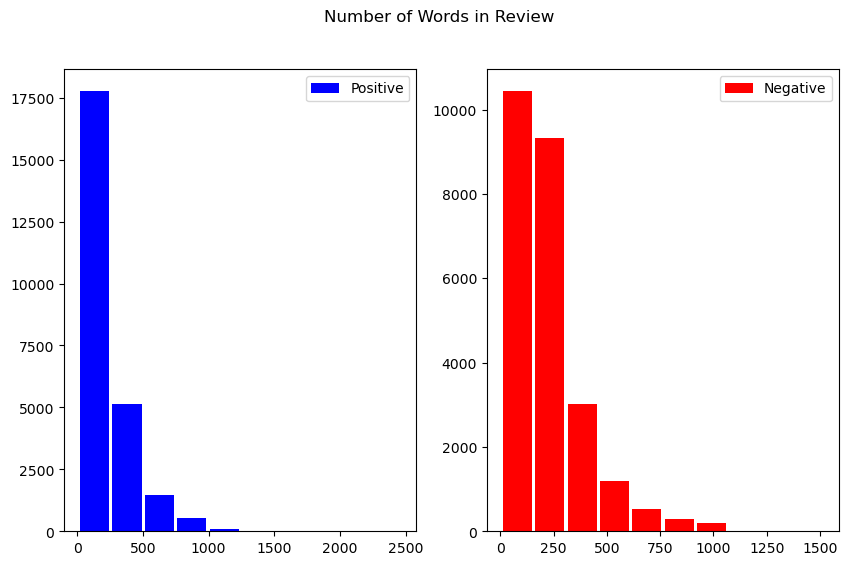

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9)
ax[0].legend(loc='upper right')

ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9)
ax[1].legend(loc='upper right')

fig.suptitle("Number of Words in Review")
plt.show()

**DataPreprocessing**

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on df

X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Converting sentiment labels to 0 & 1
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [15]:
# Split the data into training (70%) and temporary data (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary data into testing (50%) and validation (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print('Train samples: {}'.format(len(X_train)))
print('Val samples: {}'.format(len(X_val)))
print('Test samples: {}'.format(len(X_test)))

Train samples: 35000
Val samples: 7500
Test samples: 7500


**Use SpaCy for sentence splitting & tokenization**


In [16]:
# # Install spacy
# !pip install spacy

# # Download the English language model
# !python -m spacy download en


In [17]:

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser","ner"])
nlp.add_pipe('sentencizer')

def tokenize_samples(samples):

    tokenized_samples = []
    for i in tqdm(range(len(samples))):
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:
            for tok in sent:  # Iterate through the words of the sentence
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"',"'").strip())
        tokenized_samples.append(tokens)

    return tokenized_samples

C = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

  0%|          | 0/35000 [00:00<?, ?it/s]C:\Users\melin\anaconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 7500/7500 [01:38<00:00, 76.21it/s] 


In [22]:
X_train_tokenized=C

#%% Tokenization example
for item in X_train_tokenized[:2]:
     print(item, '\n')


['love', 'trains', 'stomach', 'movie', 'premise', 'steal', 'locomotive', 'drive', 'arkansas', 'chicago', 'hitting', 'train', 'way', 'right', 'impossible', 'plot', 'lines', 'hit', 'board', 'imagine', 'disgruntled', 'nasa', 'employees', 'stealing', 'crawler', 'totes', 'shuttles', 'fro', 'driving', 'new', 'york', 'idea', 'said', 'nice', 'try', 'wilford', 'brimely', 'quaker', 'oats', 'best', 'levon', 'helm', 'turns', 'good', 'performance', 'dimwitted', 'meaning', 'sidekick', 'bob', 'balaban', 'suitably', 'wormy', 'corporate', 'guy', 'little', 'guy', 'takes', 'goliath', 'story', 'gets', 'airing'] 

['good', 'ppv', 'like', 'wrestlemania', 'xx', 'years', 'later', 'wwe', 'crammed', 'matches', 'matches', 'useless', 'going', 'match', 'card', 'forever', 'major', 'highlights', 'included', 'huge', 'pop', 'demolition', 'winning', 'tag', 'team', 'belts', 'haku', 'andre', 'giant', 'mixed', 'tag', 'match', 'featuring', 'randy', 'savage', 'sensational', 'queen', 'sherri', 'vs', 'dusty', 'rhodes', 'late'

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                              max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape, type(X_train_tfidf))

(35000, 5000) <class 'scipy.sparse._csr.csr_matrix'>


**Create TFidf features**

In [21]:
# Use unigram & bi-gram tf*idf features
# Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape, type(X_train_tfidf))

(35000, 5000) <class 'scipy.sparse._csr.csr_matrix'>


**Dimentionality Reduction with SVD**

In [23]:
# Reduce dimensionality using svd 5000 --> 500
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_svd.shape, type(X_train_svd))

(35000, 500) <class 'numpy.ndarray'>


In [ ]:
#%% Normalization -> bad
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# X_train_svd = scaler.fit_transform(X_train_svd)
# X_val_svd = scaler.transform(X_val_svd)
# X_test_svd = scaler.transform(X_test_svd)

### Majority Classifier

In [24]:
#%% Baseline: Majority
#%% Dummy classifier

def my_auc_report(y_true,y_pred, title = 'UNK')->None:
    """
    Inputs the y_true and y_pred,
    Prints the PR-AUC for each class
    """
    print(f"=== PR-AUC for {title} ===")
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,0],pos_label=0)
    area = auc(recall, precision)
    print(f"PR-AUC for class 0: {area*100:.2f}%")
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,1])
    area = auc(recall, precision)
    print(f"PR-AUC for class 1: {area*100:.2f}%\n")


In [25]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train_svd, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.009581327438354492 seconds 



In [26]:
# Evaluate
model = baseline
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions,
                            target_names=['negative','positive']))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions,
                            target_names=['negative','positive']))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions,
                            target_names=['negative','positive']))

predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)

my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')


              precision    recall  f1-score   support

    negative       0.50      1.00      0.67     17589
    positive       0.00      0.00      0.00     17411

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.34     35000

              precision    recall  f1-score   support

    negative       0.50      1.00      0.66      3722
    positive       0.00      0.00      0.00      3778

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500

              precision    recall  f1-score   support

    negative       0.49      1.00      0.66      3689
    positive       0.00      0.00      0.00      3811

    accuracy                           0.49      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.24      0.49      0.32      7500

=== PR-AUC for Trai

C:\Users\melin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melin\anaconda3\Lib\site-packages\sklearn\metr

### Logistic Regression Classifier

In [27]:
#%% Baseline: Logistic
clf = LogisticRegression()
clf.fit(X_train_svd, y_train)
logit_val_accuracy = clf.score(X_val_svd, y_val)

# Evaluate
model = clf
# Classification Reports
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions, target_names=TARGET_NAMES))

# Prepare the predictions for PR-AUC
predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')


              precision    recall  f1-score   support

    negative       0.89      0.87      0.88     17589
    positive       0.87      0.90      0.88     17411

    accuracy                           0.88     35000
   macro avg       0.88      0.88      0.88     35000
weighted avg       0.88      0.88      0.88     35000

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87      3722
    positive       0.87      0.89      0.88      3778

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      3689
    positive       0.87      0.89      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

=== PR-AUC for Trai

**Custom Keras callback for calculating F1, precision, recall at the end of each epoch**

In [28]:
#%% Metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, zero_division=1)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return


### MLP classifier

In [29]:
#%% MLP
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Sequential API --> After TUNER
model = Sequential()
model.add(Dense(384, input_dim=X_train_svd.shape[1]))
# model.add(BatchNormalization())  # Add batch normalization -> Bad
model.add(Activation('relu'))  # Moved activation to after batch normalization
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary()) # Tipwnei keimeno pou perigrafei pws settarisame to network

# Configures the model for training.
# Binary_crossentropy: Computes the crossentropy loss between the label and prediction.
# Metrics -> .compile | Callbacks -> .fit
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )

if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_loss', # Save the model that scores the best @ validation accuracy
    mode='min', # Since accuracy -> maximization
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    )

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10)

start_training_time = time.time()

history = model.fit(
    X_train_svd,
    y_train,
    validation_data=(X_val_svd, y_val),
    batch_size=128,
    epochs=100,
    shuffle=True, # Shuffle the train data on every epoch
    callbacks=[Metrics(valid_data=(X_val_svd, y_val)), checkpoint, early_stopping]
    )
end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               192384    
                                                                 
 activation (Activation)     (None, 384)               0         
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 385       
                                                                 
Total params: 192769 (753.00 KB)
Trainable params: 192769 (753.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100


235/235 [==============================] - 1s 3ms/stepos
 — val_f1: 0.881076 — val_precision: 0.886626 — val_recall: 0.875596

E

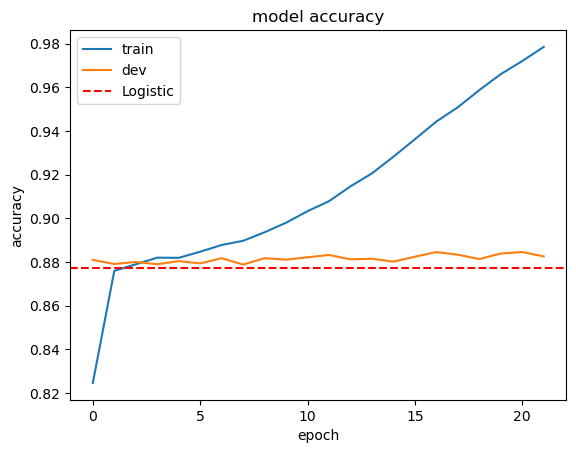

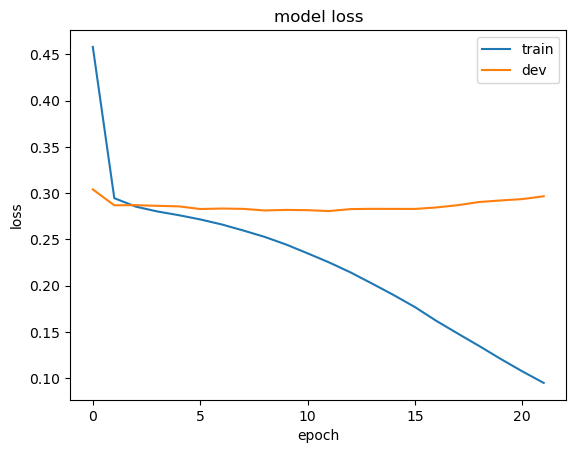

In [30]:
#%% Curves

#%% Curves
# history: Returned by the fit. Keeps the metrics for each epoch
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=logit_val_accuracy, color='red', linestyle='--', label='Logistic')
plt.legend(['train', 'dev', 'Logistic'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()


In [31]:
#%% Evaluation
predictions = (model.predict(X_train_svd) >0.5)
print(classification_report(y_train, predictions, target_names=TARGET_NAMES))
predictions = (model.predict(X_val_svd) >0.5)
print(classification_report(y_val, predictions, target_names=TARGET_NAMES))
predictions = (model.predict(X_test_svd) >0.5)
print(classification_report(y_test, predictions, target_names=TARGET_NAMES))

#%% PR-AUC
def custom_pred_proba(X)->np.ndarray[tuple[float, float]]:
    ''' Calculates the classic .predict_proba() for the X input feature matix,
        because it is needed for the precision_recall_curve.
        Returns an array: [P(x=0), P(x=1)] '''
    pred = model.predict(X)
    return np.hstack((1-pred, pred))


# Prepare predictions for PR-AUC
predictions_train = custom_pred_proba(X_train_svd)
predictions_val = custom_pred_proba(X_val_svd)
predictions_test = custom_pred_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')


1094/1094 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     17589
    positive       0.99      0.99      0.99     17411

    accuracy                           0.99     35000
   macro avg       0.99      0.99      0.99     35000
weighted avg       0.99      0.99      0.99     35000

235/235 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      3722
    positive       0.88      0.89      0.88      3778

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

235/235 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      3689
    positive       0.88      0.89      0.89      3811

    accuracy   

In [ ]:
# %% Tuner
# # !pip install -U keras-tuner
# import keras_tuner as kt
# from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=3)):
        if layer_index == 0:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh']),
                            input_dim=X_train_svd.shape[1]
                           ))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
        else:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh'])))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,
                        directory='KT_dir',
                        project_name='KT_tuning')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10)

# tuner.search_space_summary()

tuner.search(X_train_svd, y_train,
             validation_data=(X_val_svd, y_val),
             epochs=50,
             batch_size = 128,
             callbacks=[early_stopping, checkpoint])

# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

#%% Evaluate best
predictions = (best_model.predict(X_val_svd) >0.5)
print(classification_report(y_val, predictions, target_names=['negative','positive']))
